# Advanced Machine Learning: Progetto
## Parte 2 - Modello discreto per TripDuration
Progetto finale del corso di Advanced Machine Learning
<br>Anno Accademico: 2018/2019
<br>Studenti:
- Mattia Pennati - 793375
- Mirko Rima - 793435
- Francesco Rovera - 794194

## 1) Import Libraries

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from google.colab import drive
import math
from math import radians, cos, sin, asin, sqrt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras import optimizers
from keras.layers.core import Dropout
import keras
from keras.utils import np_utils

!pip install --upgrade pyGPGO
from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

Using TensorFlow backend.


  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


## 2) Load pre-created Dataset

In [0]:
drive.mount('/content/drive')
train = np.genfromtxt('drive/My Drive/AML_TaxiTripDuration_Pennati_Rima_Rovera/Dataset/DatasetFinale.csv', delimiter=',', dtype='unicode')
train= train[1:,1:]
print(train[0])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
['hour' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'trip_duration' 'tempm' 'dewptm'
 'hum' 'wspdm' 'vism' 'pressurem' 'conds' 'fog' 'rain' 'snow' 'dayweek'
 'holidays' 'month' 'distance' 'speed' 'start_zone' 'end_zone'
 'speed_disc' 'trip_duration_disc' 'distance_disc']


### 2.2) Analisi delle features

Analizzare brevemente le features del dataset e calcolarne la correlazione

               hour  passenger_count  pickup_longitude  pickup_latitude  \
count  1.227280e+06     1.227280e+06      1.227280e+06     1.227280e+06   
mean   1.360704e+01     1.661490e+00     -7.397760e+01     4.075301e+01   
std    6.385631e+00     1.312861e+00      2.657017e-02     2.382145e-02   
min    0.000000e+00     0.000000e+00     -7.420209e+01     4.055138e+01   
25%    9.000000e+00     1.000000e+00     -7.399211e+01     4.073862e+01   
50%    1.400000e+01     1.000000e+00     -7.398210e+01     4.075475e+01   
75%    1.900000e+01     2.000000e+00     -7.396877e+01     4.076854e+01   
max    2.300000e+01     7.000000e+00     -7.367950e+01     4.092044e+01   

       dropoff_longitude  dropoff_latitude  trip_duration         tempm  \
count       1.227280e+06      1.227280e+06   1.227280e+06  1.227280e+06   
mean       -7.397561e+01      4.075300e+01   7.767751e+02  1.254005e+01   
std         2.681480e-02      2.966196e-02   5.385533e+02  9.350979e+00   
min        -7.420210e+01

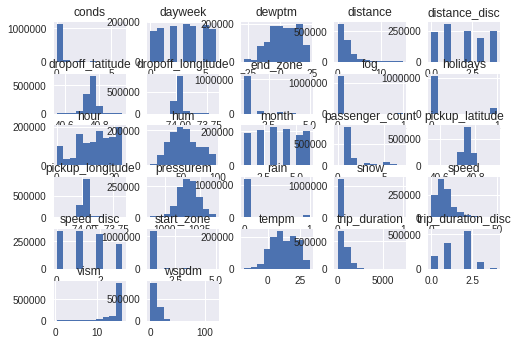

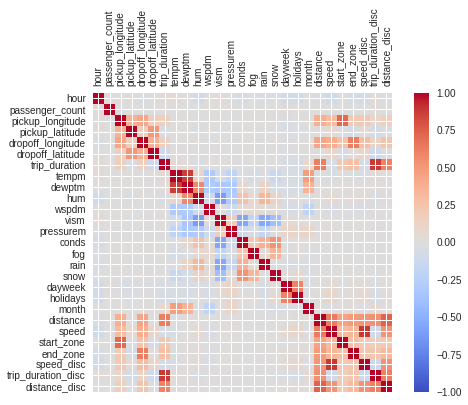

In [0]:
# Analizzare nuovamente il del dataset
data = train
columns = data[0,:]
data = data[1:,:].astype(float)
data = pd.DataFrame(data=data,columns=columns)
print(data.describe())

# Istogramma per ogni feature
data.hist()
plt.show()

# Correlazione
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [0]:

toDelete =[]
for i in range(0, len(corr['trip_duration_disc'])):
  if(np.abs(corr['trip_duration_disc'][i]) < 0.025):
    toDelete = np.append(toDelete, i)
    
train = np.delete(train, toDelete, axis = 1)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


               hour  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1.227280e+06      1.227280e+06     1.227280e+06       1.227280e+06   
mean   1.360704e+01     -7.397760e+01     4.075301e+01      -7.397561e+01   
std    6.385631e+00      2.657017e-02     2.382145e-02       2.681480e-02   
min    0.000000e+00     -7.420209e+01     4.055138e+01      -7.420210e+01   
25%    9.000000e+00     -7.399211e+01     4.073862e+01      -7.399141e+01   
50%    1.400000e+01     -7.398210e+01     4.075475e+01      -7.398020e+01   
75%    1.900000e+01     -7.396877e+01     4.076854e+01      -7.396458e+01   
max    2.300000e+01     -7.367950e+01     4.092044e+01      -7.367746e+01   

       dropoff_latitude  trip_duration         tempm           hum  \
count      1.227280e+06   1.227280e+06  1.227280e+06  1.227280e+06   
mean       4.075300e+01   7.767751e+02  1.254005e+01  5.472124e+01   
std        2.966196e-02   5.385533e+02  9.350979e+00  1.890831e+01   
min        4.055233e+01   

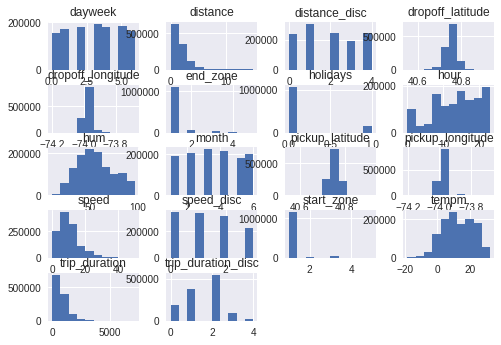

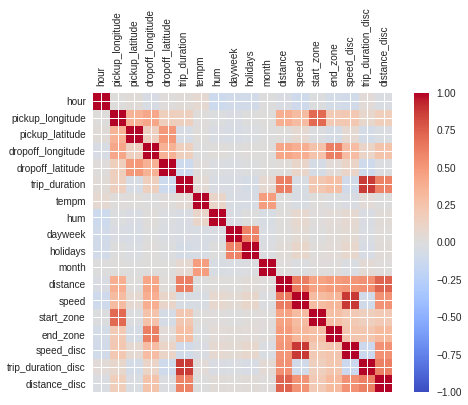

In [0]:
# Analizzare nuovamente il del dataset
data = train
columns = data[0,:]
data = data[1:,:].astype(float)
data = pd.DataFrame(data=data,columns=columns)
print(data.describe())

# Istogramma per ogni feature
data.hist()
plt.show()

# Correlazione
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### 2.1) Outliers

Trovare e rimuovere gli outliers sfruttando Z-score.

In [0]:
#Z-score
z = np.abs(stats.zscore(train[1:,:].astype(float)))
a = np.where(z > 3.5) # Soglia
b = np.where(z < -3.5)
print(a[0].shape, b[0].shape) 

print(train.shape)
train = np.delete(train, [a[0]], axis=0)
print(train.shape)

print(pd.value_counts(train[1:,16]))


(194306,) (0,)
(1227281, 18)
(1137115, 18)
2    507513
1    347684
0    173765
3     91342
4     16810
dtype: int64


In [0]:
print(train[0])

['hour' 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'trip_duration' 'tempm' 'hum' 'dayweek' 'holidays'
 'month' 'distance' 'speed' 'start_zone' 'end_zone' 'speed_disc'
 'trip_duration_disc' 'distance_disc']


## 3) Model

Definire una rete neurale che funga da classificatore e addestrarla sul dataset di riferimento.

### 3.1) Definizione del modello
Scegliere la variabile target ( 6:"trip_duration"), suddividere il train set in train e validation e definire il modello di riferimento.
<br> Abbiamo precedentemente creato l'attributo speed in fase di analisi per un controllo dei dati, risultando poi poco utile e poichè avrebbe influenzato il nostro modello ELIMINIAMO le istanze di "speed".
<br> OSS: non si considerano più di due livelli di neuroni nascosti per il numero non elevato di features da analizzare.

In [0]:
tripDurationColumn = 5
tripDurationDiscColumn = 16
speedColumn = 12
speedDiscColumn = 15
print(train.shape)

(1137115, 18)


In [0]:
nb_classes = 5

# Variabile target: trip duration 
tlabels = train[1:,16]
train = np.delete(train, [16, 5, 12, 15], axis=1)
print(train[0])

train = preprocessing.scale(train[1:,])

['hour' 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'tempm' 'hum' 'dayweek' 'holidays' 'month' 'distance'
 'start_zone' 'end_zone' 'distance_disc']


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# Split del training set
train, validation, tlabels, vlabels = train_test_split(train[:,:],
                                                       tlabels,
                                                       test_size = 0.25,
                                                       random_state=42)

tlabels = np_utils.to_categorical(tlabels)
vlabels = np_utils.to_categorical(vlabels)

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1) 

dims = train.shape[1]
batch_size = 256
epochs = 20

model = Sequential()
model.add(Dense(32, input_shape=(dims,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax')) 
model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 1,093
Trainable params: 1,093
Non-trainable params: 0
___________________

### 3.2) Fase di training del modello e risultati

Addestrare la rete definita in precedenza e visualizzarne i risultati in termini di Accuracy sul validation set.

In [0]:
network_history = model.fit(train, tlabels, 
                            batch_size= batch_size, 
                            epochs = epochs, 
                            verbose=1, 
                            validation_data=(validation, vlabels),
                            callbacks=[early_stop]) 

Instructions for updating:
Use tf.cast instead.
Train on 852835 samples, validate on 284279 samples
Epoch 1/20
852835/852835 [==============================] - 20s 24us/step - loss: 0.9110 - acc: 0.5948 - val_loss: 0.7821 - val_acc: 0.6620
Epoch 2/20
852835/852835 [==============================] - 18s 21us/step - loss: 0.8187 - acc: 0.6426 - val_loss: 0.7557 - val_acc: 0.6743
Epoch 3/20
852835/852835 [==============================] - 18s 21us/step - loss: 0.7976 - acc: 0.6522 - val_loss: 0.7434 - val_acc: 0.6796
Epoch 4/20
852835/852835 [==============================] - 18s 21us/step - loss: 0.7882 - acc: 0.6574 - val_loss: 0.7365 - val_acc: 0.6818
Epoch 5/20
852835/852835 [==============================] - 18s 21us/step - loss: 0.7833 - acc: 0.6603 - val_loss: 0.7320 - val_acc: 0.6865
Epoch 6/20
852835/852835 [==============================] - 18s 21us/step - loss: 0.7794 - acc: 0.6619 - val_loss: 0.7293 - val_acc: 0.6856
Epoch 7/20
852835/852835 [==============================] - 

## 4) Optimization

Utilizzare Grid Search e Ottimizzazione Bayesiana tramite Gaussian Process e Random Forest per ottenere i migliori iper-parametri per il modello

### 4.1) Definizione modello

In [0]:
def NNmodel(loss, opt, unitlevel1, unitlevel2, batchsize):  
  
  #early stoop
  early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1) 

  dims = train.shape[1]
  epochs = 10
  
  # Ri-creazione del dataset
  dataset = np.concatenate((train,validation)).astype(float)
  label = np.concatenate((tlabels,vlabels)).astype(float)
  dataset = dataset[0:100000,:]
  label = label[0:100000]
  # Creazione delle 5 fold (dataset già "shuffled nella division in train/val")
  datasets = np.array_split(dataset, 5)
  labels = np.array_split(label, 5)
  # Vettore dei risultati
  cvscores = []
  tests = [0,1,2,3,4]
  
  # 5-fold cross validation
  for i in range(0,5):
    # Train e test
    ts = datasets[tests[i]]
    tsl = labels[tests[i]]
    trains = [0,1,2,3,4]
    trains.remove(tests[i])
    args = (datasets[trains[0]],datasets[trains[1]],datasets[trains[2]],
            datasets[trains[3]])
    tr = np.concatenate(args,axis=0)
    args = (labels[trains[0]],labels[trains[1]],labels[trains[2]],
            labels[trains[3]])
    trl = np.concatenate(args,axis=0)
    
    # Modello
    model = Sequential()
    unitlevel1 = int(unitlevel1)
    unitlevel2 = int(unitlevel2)
    model.add(Dense(unitlevel1, input_shape=(dims,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(unitlevel2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes, activation='softmax'))
    
    model.compile(loss=loss,
                  optimizer= opt,
                  metrics=['acc'])
    
    h = model.fit(tr,
                  trl,
                  batch_size= batchsize,
                  epochs = epochs, 
                  verbose=0, validation_data=(ts, tsl),callbacks=[early_stop])  
    
    # Valutazione del modello
    score = h.history['val_acc'][len(h.history['val_acc'])-1]
    cvscores.append(score)
  print('Accuracy --> ', sum(cvscores)/len(cvscores),"\n")
  return (sum(cvscores)/len(cvscores))

In [0]:
def NNmodel2(lr, unit1, unit2):
  opt= optimizers.Adadelta (lr = lr)
  unit1 = math.floor(unit1)
  unit2 = math.floor(unit2)
  early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
  print('Config --> lr = ', lr, 'unit1 = ', unit1, 'unit2 = ', unit2)
  # Ri-creazione del dataset
  dataset = (np.concatenate((train,validation)).astype(float))
  dataset = dataset[0:100000,:]
  label = (np.concatenate((tlabels,vlabels)).astype(float))
  label = label[0:100000]
  dims = train.shape[1]
  
  # Creazione delle 5 fold (dataset già "shuffled nella division in train/val")
  datasets = np.array_split(dataset, 5)
  labels = np.array_split(label, 5)
  # Vettore dei risultati
  cvscores = []
  tests = [0,1,2,3,4]
  # 5-fold cross validation
  for i in range(0,5):
    # Train e test
    ts = datasets[tests[i]]
    tsl = labels[tests[i]]
    trains = [0,1,2,3,4]
    trains.remove(tests[i])
    args = (datasets[trains[0]],datasets[trains[1]],datasets[trains[2]],
            datasets[trains[3]])
    tr = np.concatenate(args,axis=0)
    args = (labels[trains[0]],labels[trains[1]],labels[trains[2]],
            labels[trains[3]])
    trl = np.concatenate(args,axis=0)
    
    # Modello
    model = Sequential()
    model.add(Dense((int)(unit1), input_shape=(dims,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense((int)(unit2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
    
    h = model.fit(tr,
                  trl,
                  batch_size= 128,
                  epochs = 10, 
                  verbose=0, validation_data=(ts, tsl),callbacks=[early_stop])  
    
    # Valutazione del modello
    score = h.history['val_acc'][len(h.history['val_acc'])-1]
    cvscores.append(score)
    
  print('Accuracy --> ', sum(cvscores)/len(cvscores),"\n")
  return (sum(cvscores)/len(cvscores))

### 4.2) GridSearch

In [0]:
# Definire il range dei parametri (24)
lossrange = ['categorical_crossentropy']      
optrange = ['adam', 'adadelta', 'sgd']     
unitlevel1range = [32, 64]
unitlevel2range = [8, 16]
batchsizerange = [128, 256]

rng = len(lossrange)*len(optrange)*len(unitlevel1range)*len(unitlevel2range)*len(batchsizerange)
res = [0 for n in range(rng)]
count = 0
best = 0
bestparameters = ['','',0,0,0]
for l in lossrange:
  for u1 in unitlevel1range:
    for u2 in unitlevel2range:
      for b in batchsizerange:
          for o in optrange:
            print('Configuration ',count ,' --> unitlevel1 = ',u1 ,' unitlevel2 = ',u2,' batchsize = ', b, ' loss = ', l, ' opt = ', o)
            res[count] = NNmodel(l,o,u1,u2,b)
            if(res[count]>best):
              best = res[count]
              bestparameters = [l,o,u1,u2,b]
            count = count+1

Configuration  0  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  128  loss =  categorical_crossentropy  opt =  adam
Accuracy -->  0.66446 

Configuration  1  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  128  loss =  categorical_crossentropy  opt =  adadelta
Accuracy -->  0.66144 

Configuration  2  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  128  loss =  categorical_crossentropy  opt =  sgd
Accuracy -->  0.5386599999999999 

Configuration  3  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  256  loss =  categorical_crossentropy  opt =  adam
Accuracy -->  0.65285 

Configuration  4  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  256  loss =  categorical_crossentropy  opt =  adadelta
Accuracy -->  0.66005 

Configuration  5  --> unitlevel1 =  32  unitlevel2 =  8  batchsize =  256  loss =  categorical_crossentropy  opt =  sgd
Accuracy -->  0.5274 

Configuration  6  --> unitlevel1 =  32  unitlevel2 =  16  batchsize =  128  loss =  categorical_crossentropy  opt 

Best acc on the grid:0.678
Best parameters: Loss function= categorical_crossentropy , Optimization function = adadelta , Hidden level 1 units=  64 , Hidden level 2 units=  16 , Batch size=  128


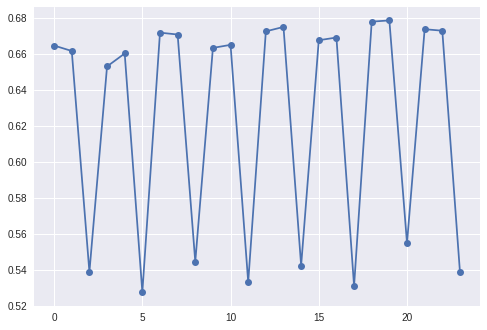

In [0]:
plt.plot(res, marker="o")
print("Best acc on the grid:"+str(np.round(max(np.asarray(res)),3)))
print("Best parameters: Loss function=", bestparameters[0], 
      ", Optimization function =", bestparameters[1],
      ", Hidden level 1 units= ", bestparameters[2],
      ", Hidden level 2 units= ", bestparameters[3],
      ", Batch size= ",bestparameters[4])

### 4.3) Ottimizzazione Bayesiana - Gaussian Process

Definire i parametri da ottimizzare, un dizionario e una combinatoria di casi

In [0]:
param = {'lr': ('cont', [0.70,1.3]), 'unit1': ('cont', [52, 76]), 'unit2': ('cont', [6, 26])}

#define a covariance function for the Gaussian Process
sqrexp = squaredExponential()

#define Gaussian process
gp = GaussianProcess(covfunc=sqrexp)

#setting the acquisition function
acq = Acquisition(mode="ExpectedImprovement")

#creating an object Bayesian Optimization
#GPGO(surrogate model, acquisition function, 
# function to be optimized (the model),  parameters to optimize the model, 
# number of threads)
bayesian_opt = GPGO(gp, acq, NNmodel2, param, n_jobs=1)

#performs initial evaluations before fitting GP
initialpoints = 10 #number of initial points to use
bayesian_opt._firstRun(n_eval = 10)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Config --> lr =  1.0843436209900694 unit1 =  74 unit2 =  21
Accuracy -->  0.6839299999999999 

Config --> lr =  1.2141813382579747 unit1 =  56 unit2 =  21
Accuracy -->  0.68229 

Config --> lr =  1.1468916438170647 unit1 =  71 unit2 =  9
Accuracy -->  0.67633 

Config --> lr =  0.817904797455071 unit1 =  69 unit2 =  13
Accuracy -->  0.6740499999999999 

Config --> lr =  0.7260699358295375 unit1 =  53 unit2 =  8
Accuracy -->  0.66696 

Config --> lr =  1.1986098817893955 unit1 =  67 unit2 =  22
Accuracy -->  0.68286 

Config --> lr =  0.815823800234173 unit1 =  72 unit2 =  15
Accuracy -->  0.6766099999999999 

Config --> lr =  0.9740737318078209 unit1 =  75 unit2 =  11
Accuracy -->  0.67729 

Config --> lr =  1.2880813328542762 unit1 =  72 unit2 =  18
Accuracy -->  0.68129 

Config --> lr =  0.9382695285283263 unit1 =  52 unit2 =  6
Accuracy -->  0.66926 



In [0]:
# Dizionario
lrRange = list(param.values())[0][1]
u1Range = list(param.values())[1][1]
u2Range = list(param.values())[2][1]

xs = np.linspace(lrRange[0],lrRange[1],10).reshape((10,1))
ys = np.linspace(u1Range[0],u1Range[1],10).reshape((10,1))
zs = np.linspace(u2Range[0],u2Range[1],10).reshape((10,1))

xx,yy, zz = np.meshgrid(xs,ys, zs)

pp = [[0 for j in range(3)] for i in range(len(xs)*len(ys)*len(zs))]

for i in range(len(xs)):
    for j in range(len(ys)):
      for k in range(len(zs)):
        pp[(i*len(ys))+len(zs)*j+k][2] = zs[k]
        pp[(i*len(ys))+len(zs)*j+k][0] = xs[i]
        pp[(i*len(ys))+len(zs)*j+k][1] = ys[j]
pp = np.asarray(pp).reshape(len(xs)*len(ys)*len(zs),3)

In [0]:
#make prediction, optimization of acquistion function and update of the 
# bayesian optimization object 
furtherEvaluations = 25
print('Start furtherEvals')
for iter in range(furtherEvaluations):
    #make prediction with bayesian optimizer
    predictions = bayesian_opt.GP.predict(pp,return_std=True)
    
    #a = -bayesian_opt._acqWrapper(pp)
    
    #optimizes the acquisition function using a multistart approach
    bayesian_opt._optimizeAcq(method='L-BFGS-B', n_start=100)
    #update the gaussian process
    bayesian_opt.updateGP()

Start furtherEvals
Config --> lr =  0.8323291483539342 unit1 =  52 unit2 =  7
Accuracy -->  0.66815 

Config --> lr =  1.0538270338336353 unit1 =  72 unit2 =  17
Accuracy -->  0.68003 

Config --> lr =  1.0240540352295335 unit1 =  73 unit2 =  18
Accuracy -->  0.6811800000000001 

Config --> lr =  0.7658579308407667 unit1 =  73 unit2 =  16
Accuracy -->  0.67615 

Config --> lr =  1.1201223953561759 unit1 =  74 unit2 =  20
Accuracy -->  0.68238 

Config --> lr =  0.8868770103946629 unit1 =  75 unit2 =  20
Accuracy -->  0.6792199999999999 

Config --> lr =  0.7 unit1 =  72 unit2 =  19
Accuracy -->  0.6768799999999999 

Config --> lr =  0.8189919841106322 unit1 =  70 unit2 =  14
Accuracy -->  0.67641 

Config --> lr =  0.8450558207635201 unit1 =  70 unit2 =  13
Accuracy -->  0.67527 

Config --> lr =  0.7 unit1 =  74 unit2 =  19
Accuracy -->  0.67681 

Config --> lr =  1.3 unit1 =  73 unit2 =  19
Accuracy -->  0.68462 

Config --> lr =  1.2415665129047535 unit1 =  53 unit2 =  6
Accuracy --

Best parameters (acq(): Expected Improvement): 

Learning Rate= 1.0501375107616264 Unit1= 75 Unit2= 10
ACCURACY:  0.685 

-----------------------------------------------------------------------
Plot of the BO with gaussian process and acq(): Expected Improvement


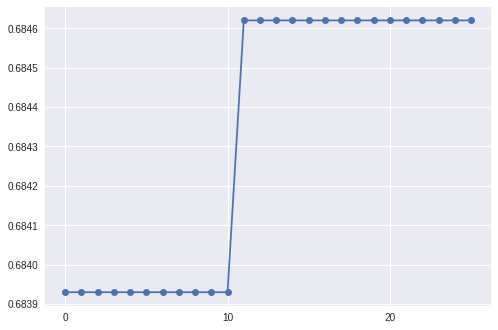

In [0]:
#best parameters configuration
print("Best parameters (acq(): Expected Improvement): \n")
print("Learning Rate=", bayesian_opt.best[0], "Unit1=", int(bayesian_opt.best[1]), "Unit2=", int(bayesian_opt.best[2]) )
print("ACCURACY: ", np.round(np.max(bayesian_opt.history), 3), "\n")
print("-----------------------------------------------------------------------")

#bayesian_opt plot
plt.xticks(np.arange(0, 121, step=10))
print("Plot of the BO with gaussian process and acq(): Expected Improvement")
plt.plot(bayesian_opt.history, marker="o")
plt.show()

## 5) Modello finale
Implementazione del modello finale con i migliori iper-parametri ottenuti dopo l'ottimizzazione, fase di training sull'intero dataset e visualizzazione dei risultati.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 75)                1125      
_________________________________________________________________
dropout_7 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                760       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Train on 852835 samples, validate on 284279 samples
Epoch 1/30
852835/852835 [==============================] - 37s 43us/step - loss: 0.8551

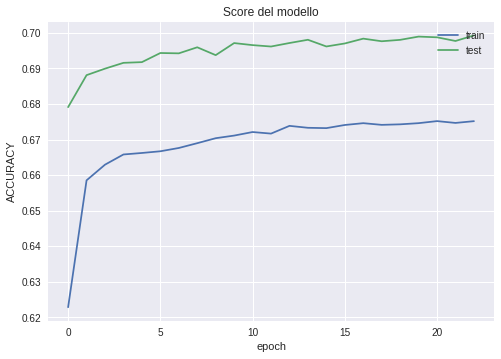

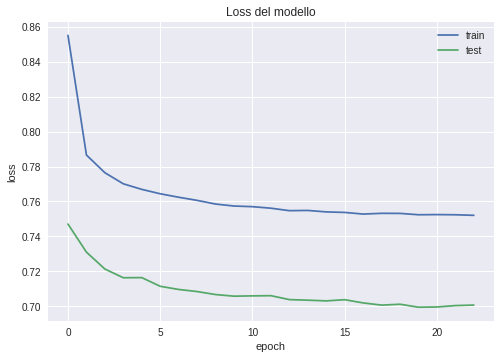

In [0]:
dims = train.shape[1]
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


model = Sequential()
model.add(Dense(75, input_shape=(dims,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax')) 
model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer = optimizers.Adadelta(lr = 1.050), 
              metrics=['accuracy'])

network_history = model.fit(train, tlabels, 
                            batch_size= 128, 
                            epochs = 30, 
                            verbose=1, 
                            validation_data=(validation, vlabels),
                            callbacks=[early_stop]) 

# Visualizzazione dei risultati
trainscore = network_history.history['acc'][len(network_history.history['acc'])-1]
valscore = network_history.history['val_acc'][len(network_history.history['val_acc'])-1]
print("ACCURACY finale sul training set: ", np.round(trainscore,3))
print("ACCURACY finale sul validation set: ", np.round(valscore,3))

# Plot per Accuracy
plt.plot(network_history.history['acc'])
plt.plot(network_history.history['val_acc'])
plt.title('Score del modello')
plt.ylabel('ACCURACY')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Plot per la loss
plt.plot(network_history.history['loss'])
plt.plot(network_history.history['val_loss'])
plt.title('Loss del modello')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

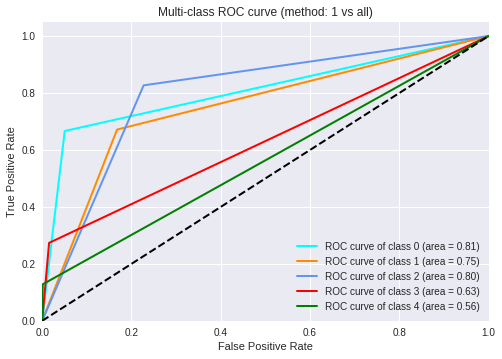

In [0]:
#predizioni 
preds = np_utils.to_categorical(model.predict_classes(validation))

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(vlabels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(vlabels.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve (method: 1 vs all)')
plt.legend(loc="lower right")
plt.show()